**Important: This notebook will only work with fastai-0.7.x. Do not try to run any fastai-1.x code from this path in the repository because it will load fastai-0.7.x**

# Random Forest Model interpretation

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline

from fastai.imports import *
from fastai.structured import *
# from pandas_summary import DataFrameSummary
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from IPython.display import display
from sklearn import metrics

/Users/shaojun/opt/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.ensemble.forest module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.ensemble. Anything that cannot be imported from sklearn.ensemble is now part of the private API.
  warnings.warn(message, FutureWarning)


In [3]:
set_plot_sizes(12,14,16)

## Load in our data from last lesson

In [4]:
PATH = "data/bulldozers/"

df_raw = pd.read_feather('tmp/bulldozers-raw')
df_trn, y_trn, nas = proc_df(df_raw, 'SalePrice')

In [5]:
def split_vals(a,n): return a[:n], a[n:]
n_valid = 12000
n_trn = len(df_trn)-n_valid
X_train, X_valid = split_vals(df_trn, n_trn)
y_train, y_valid = split_vals(y_trn, n_trn)
raw_train, raw_valid = split_vals(df_raw, n_trn)

In [6]:
def rmse(x,y): return math.sqrt(((x-y)**2).mean())

def get_scores(m, config=None):
    res = {
        'config': [config],
        'rmse_train': [rmse(m.predict(X_train), y_train)],
        'rmse_dev': [rmse(m.predict(X_valid), y_valid)],
        'r2_train': [m.score(X_train, y_train)],
        'r2_dev': [m.score(X_valid, y_valid)],
        'r2_oob': [None],
        'n_trees':[m.n_estimators],
        'train_size': [len(y_train)],
        'dev_size': [len(y_valid)],
    }
    if hasattr(m, 'oob_score_'): res['r2_oob'][0] = m.oob_score_
    return pd.DataFrame(res)

In [7]:
df_raw

,SalesID,SalePrice,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,fiModelDesc,...,saleDay,saleDayofweek,saleDayofyear,saleIs_month_end,saleIs_month_start,saleIs_quarter_end,saleIs_quarter_start,saleIs_year_end,saleIs_year_start,saleElapsed
0,1139246,11.097410,999089,3157,121,3.0,2004,68.0,Low,521D,...,16,3,320,False,False,False,False,False,False,1163635200
1,1139248,10.950807,117657,77,121,3.0,1996,4640.0,Low,950FII,...,26,4,86,False,False,False,False,False,False,1080259200
2,1139249,9.210340,434808,7009,121,3.0,2001,2838.0,High,226,...,26,3,57,False,False,False,False,False,False,1077753600
3,1139251,10.558414,1026470,332,121,3.0,2001,3486.0,High,PC120-6E,...,19,3,139,False,False,False,False,False,False,1305763200
4,1139253,9.305651,1057373,17311,121,3.0,2007,722.0,Medium,S175,...,23,3,204,False,False,False,False,False,False,1248307200
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
401120,6333336,9.259131,1840702,21439,149,1.0,2005,NaN,NaN,35NX2,...,2,2,306,False,False,False,False,False,False,1320192000
401121,6333337,9.305651,1830472,21439,149,1.0,2005,NaN,NaN,35NX2,...,2,2,306,False,False,False,False,False,False,1320192000
401122,6333338,9.350102,1887659,21439,149,1.0,2005,NaN,NaN,35NX2,...,2,2,306,False,False,False,False,False,False,1320192000
401123,6333341,9.104980,1903570,21435,149,2.0,2005,NaN,NaN,30NX,...,25,1,298,False,False,False,False,False,False,1319500800


# Confidence based on tree variance

For model interpretation, there's no need to use the full dataset on each tree - using a subset will be both faster, and also provide better interpretability (since an overfit model will not provide much variance across trees).

In [8]:
set_rf_samples(50000)

In [9]:
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features=0.5, max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=3,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=40, n_jobs=-1, oob_score=True,
                      random_state=None, verbose=0, warm_start=False)

In [10]:
results = get_scores(m, 'baseline-subsample-tuning')
results

,config,rmse_train,rmse_dev,r2_train,r2_dev,r2_oob,n_trees,train_size,dev_size
0,baseline-subsample-tuning,0.119149,0.229098,0.97033,0.906267,0.911704,40,389125,12000


We saw how the model averages predictions across the trees to get an estimate - but how can we know the confidence of the estimate? One simple way is to use the standard deviation of predictions, instead of just the mean. This tells us the *relative* confidence of predictions - that is, for rows where the trees give very different results, you would want to be more cautious of using those results, compared to cases where they are more consistent. Using the same example as in the last lesson when we looked at bagging:

In [11]:
%time preds = np.stack([t.predict(X_valid) for t in m.estimators_])
np.mean(preds[:,0]), np.std(preds[:,0])

CPU times: user 1.29 s, sys: 9.95 ms, total: 1.3 s
Wall time: 1.31 s


(9.187508800938087, 0.247374573036792)

When we use python to loop through trees like this, we're calculating each in series, which is slow! We can use parallel processing to speed things up:

In [12]:
def get_preds(t): return t.predict(X_valid)
%time preds = np.stack(parallel_trees(m, get_preds))
np.mean(preds[:,0]), np.std(preds[:,0])

CPU times: user 237 ms, sys: 178 ms, total: 415 ms
Wall time: 931 ms


(9.187508800938087, 0.247374573036792)

We can see that different trees are giving different estimates this this auction. In order to see how prediction confidence varies, we can add this into our dataset.

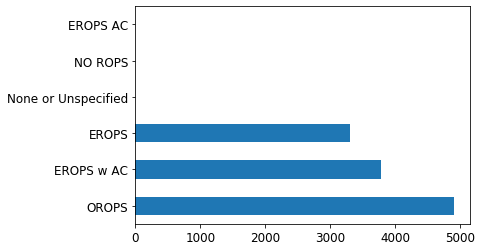

In [13]:
x = raw_valid.copy()
x['pred_std'] = np.std(preds, axis=0)
x['pred'] = np.mean(preds, axis=0)
x.Enclosure.value_counts().plot.barh();

In [14]:
flds = ['Enclosure', 'SalePrice', 'pred', 'pred_std']
enc_summ = x[flds].groupby('Enclosure', as_index=False).mean()
enc_summ

,Enclosure,SalePrice,pred,pred_std
0,EROPS,9.849178,9.835162,0.248387
1,EROPS AC,NaN,NaN,NaN
2,EROPS w AC,10.623971,10.590281,0.228353
3,NO ROPS,NaN,NaN,NaN
4,None or Unspecified,NaN,NaN,NaN
5,OROPS,9.682064,9.678038,0.201809


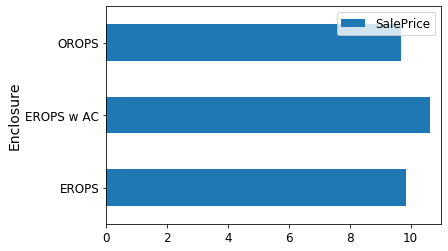

In [15]:
enc_summ = enc_summ[~pd.isnull(enc_summ.SalePrice)]
enc_summ.plot('Enclosure', 'SalePrice', 'barh', xlim=(0,11));

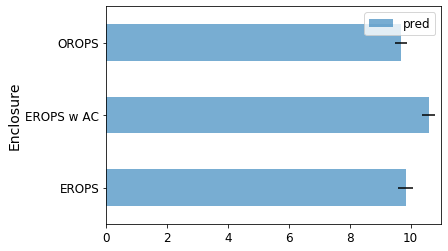

In [16]:
enc_summ.plot('Enclosure', 'pred', 'barh', xerr='pred_std', alpha=0.6, xlim=(0,11));

*Question*: Why are the predictions nearly exactly right, but the error bars are quite wide?

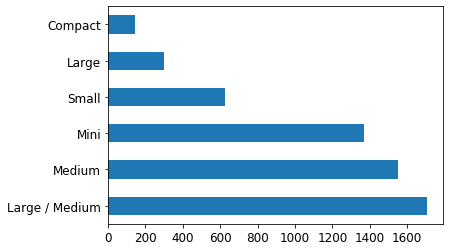

In [17]:
raw_valid.ProductSize.value_counts().plot.barh();

In [18]:
flds = ['ProductSize', 'SalePrice', 'pred', 'pred_std']
summ = x[flds].groupby(flds[0]).mean()
summ

,SalePrice,pred,pred_std
ProductSize,,,
Compact,9.735093,9.817741,0.291646
Large,10.470589,10.408963,0.320635
Large / Medium,10.691871,10.660464,0.270421
Medium,10.681511,10.627580,0.241763
Mini,9.535147,9.560620,0.221506
Small,10.324448,10.325736,0.270924


In [19]:
(summ.pred_std/summ.pred).sort_values(ascending=False)

ProductSize
Large             0.030804
Compact           0.029706
Small             0.026238
Large / Medium    0.025367
Mini              0.023169
Medium            0.022749
dtype: float64

# Feature importance

It's not normally enough to just to know that a model can make accurate predictions - we also want to know *how* it's making predictions. The most important way to see this is with *feature importance*.

In [20]:
fi = rf_feat_importance(m, df_trn); fi[:10]

,cols,imp
5,YearMade,0.169939
13,ProductSize,0.101186
37,Coupler_System,0.091113
14,fiProductClassDesc,0.081395
39,Hydraulics_Flow,0.062406
2,ModelID,0.056608
63,saleElapsed,0.052768
10,fiSecondaryDesc,0.048676
38,Grouser_Tracks,0.035881
19,Enclosure,0.035146


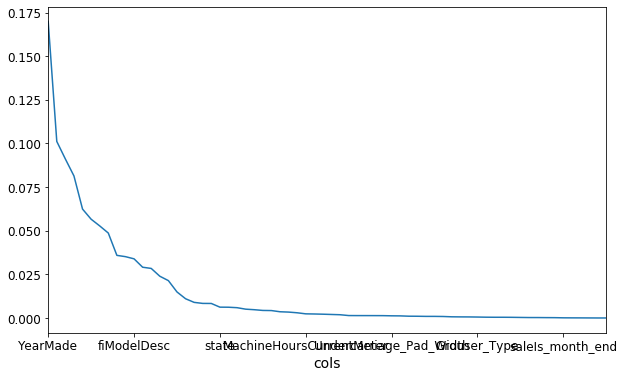

In [21]:
fi.plot('cols', 'imp', figsize=(10,6), legend=False);

In [22]:
def plot_fi(fi): return fi.plot('cols', 'imp', 'barh', figsize=(12,7), legend=False)

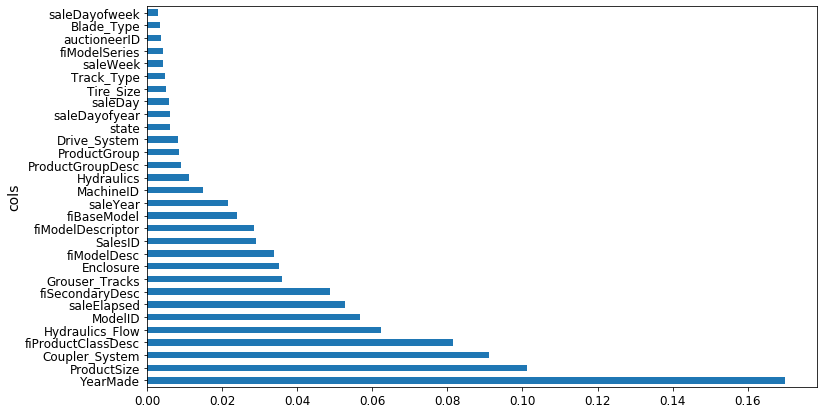

In [23]:
plot_fi(fi[:30]);

In [24]:
to_keep = fi[fi.imp>0.005].cols; len(to_keep)

24

In [25]:
df_keep = df_trn[to_keep].copy()
X_train, X_valid = split_vals(df_keep, n_trn)

In [26]:
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5,
                          n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features=0.5, max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=3,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=40, n_jobs=-1, oob_score=True,
                      random_state=None, verbose=0, warm_start=False)

In [27]:
tmp = get_scores(m, 'fi')
tmp

,config,rmse_train,rmse_dev,r2_train,r2_dev,r2_oob,n_trees,train_size,dev_size
0,fi,0.124037,0.225316,0.967846,0.909337,0.910046,40,389125,12000


In [28]:
results = pd.concat([tmp, results])
results[::-1]

,config,rmse_train,rmse_dev,r2_train,r2_dev,r2_oob,n_trees,train_size,dev_size
0,baseline-subsample-tuning,0.119149,0.229098,0.970330,0.906267,0.911704,40,389125,12000
0,fi,0.124037,0.225316,0.967846,0.909337,0.910046,40,389125,12000


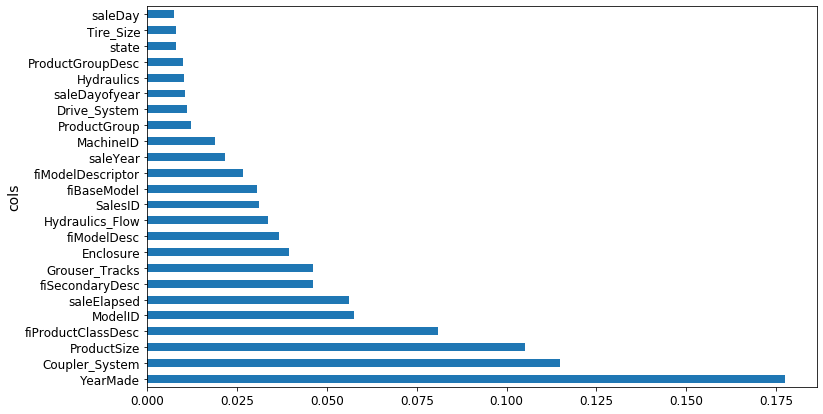

In [29]:
fi = rf_feat_importance(m, df_keep)
plot_fi(fi);

## One-hot encoding

proc_df's optional *max_n_cat* argument will turn some categorical variables into new columns.

For example, the column **ProductSize** which has 6 categories:

* Large
* Large / Medium
* Medium
* Compact
* Small
* Mini

gets turned into 6 new columns:

* ProductSize_Large
* ProductSize_Large / Medium
* ProductSize_Medium
* ProductSize_Compact
* ProductSize_Small
* ProductSize_Mini

and the column **ProductSize** gets removed.

It will only happen to columns whose number of categories is no bigger than the value of the *max_n_cat* argument.

Now some of these new columns may prove to have more important features than in the earlier situation, where all categories were in one column.

In [30]:
df_trn2, y_trn, nas = proc_df(df_raw, 'SalePrice', max_n_cat=7)
X_train, X_valid = split_vals(df_trn2, n_trn)

m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.6, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features=0.6, max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=3,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=40, n_jobs=-1, oob_score=True,
                      random_state=None, verbose=0, warm_start=False)

In [31]:
tmp = get_scores(m, 'one-hot')
tmp

,config,rmse_train,rmse_dev,r2_train,r2_dev,r2_oob,n_trees,train_size,dev_size
0,one-hot,0.118197,0.233198,0.970802,0.902882,0.910315,40,389125,12000


In [32]:
results = pd.concat([tmp, results])
results[::-1]

,config,rmse_train,rmse_dev,r2_train,r2_dev,r2_oob,n_trees,train_size,dev_size
0,baseline-subsample-tuning,0.119149,0.229098,0.970330,0.906267,0.911704,40,389125,12000
0,fi,0.124037,0.225316,0.967846,0.909337,0.910046,40,389125,12000
0,one-hot,0.118197,0.233198,0.970802,0.902882,0.910315,40,389125,12000


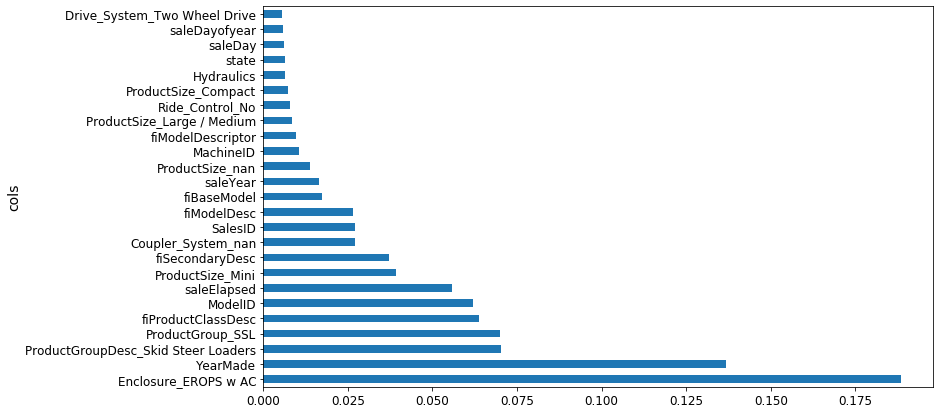

In [33]:
fi = rf_feat_importance(m, df_trn2)
plot_fi(fi[:25]);

# Removing redundant features

One thing that makes this harder to interpret is that there seem to be some variables with very similar meanings. Let's try to remove redundent features.

In [34]:
from scipy.cluster import hierarchy as hc

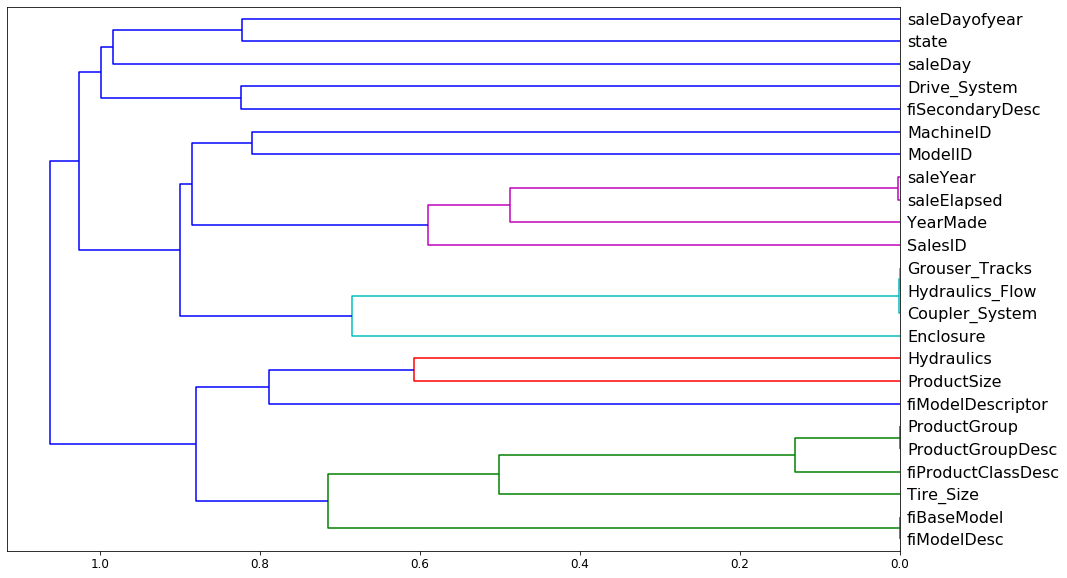

In [35]:
corr = np.round(scipy.stats.spearmanr(df_keep).correlation, 4)
corr_condensed = hc.distance.squareform(1-corr)
z = hc.linkage(corr_condensed, method='average')
fig = plt.figure(figsize=(16,10))
dendrogram = hc.dendrogram(z, labels=df_keep.columns, orientation='left', leaf_font_size=16)
plt.show()

In [36]:
sorted(list(df_keep.columns))

['Coupler_System',
 'Drive_System',
 'Enclosure',
 'Grouser_Tracks',
 'Hydraulics',
 'Hydraulics_Flow',
 'MachineID',
 'ModelID',
 'ProductGroup',
 'ProductGroupDesc',
 'ProductSize',
 'SalesID',
 'Tire_Size',
 'YearMade',
 'fiBaseModel',
 'fiModelDesc',
 'fiModelDescriptor',
 'fiProductClassDesc',
 'fiSecondaryDesc',
 'saleDay',
 'saleDayofyear',
 'saleElapsed',
 'saleYear',
 'state']

In [37]:
len(corr), len(corr[0])

(24, 24)

Let's try removing some of these related features to see if the model can be simplified without impacting the accuracy.

In [38]:
def get_oob(df):
    m = RandomForestRegressor(n_estimators=30, min_samples_leaf=5, max_features=0.6, n_jobs=-1, oob_score=True)
    x, _ = split_vals(df, n_trn)
    m.fit(x, y_train)
    return m.oob_score_

Here's our baseline.

In [39]:
get_oob(df_keep)

/Users/shaojun/opt/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/_forest.py:815: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


0.9064472139495289

Now we try removing each variable one at a time.

In [40]:
for c in ('saleYear', 'saleElapsed', 'fiModelDesc', 'fiBaseModel', 'Grouser_Tracks', 'Coupler_System'):
    print(c, get_oob(df_keep.drop(c, axis=1)))

saleYear 0.9064801457980415
saleElapsed 0.9045097838104813
fiModelDesc 0.9060148656368917


/Users/shaojun/opt/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/_forest.py:815: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


fiBaseModel 0.9056241575763678
Grouser_Tracks 0.9065842687260266
Coupler_System 0.906033370103782


/Users/shaojun/opt/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/_forest.py:815: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


It looks like we can try one from each group for removal. Let's see what that does.

In [41]:
to_drop = ['saleYear', 'fiBaseModel', 'Grouser_Tracks']
get_oob(df_keep.drop(to_drop, axis=1))

0.9059582814992788

Looking good! Let's use this dataframe from here. We'll save the list of columns so we can reuse it later.

In [42]:
df_keep.drop(to_drop, axis=1, inplace=True)
X_train, X_valid = split_vals(df_keep, n_trn)

In [43]:
# np.save('tmp/keep_cols.npy', np.array(df_keep.columns))

In [44]:
# keep_cols = np.load('tmp/keep_cols.npy')
# df_keep = df_trn[keep_cols]
keep_cols = df_keep.columns

In [45]:
sorted(list(keep_cols))

['Coupler_System',
 'Drive_System',
 'Enclosure',
 'Hydraulics',
 'Hydraulics_Flow',
 'MachineID',
 'ModelID',
 'ProductGroup',
 'ProductGroupDesc',
 'ProductSize',
 'SalesID',
 'Tire_Size',
 'YearMade',
 'fiModelDesc',
 'fiModelDescriptor',
 'fiProductClassDesc',
 'fiSecondaryDesc',
 'saleDay',
 'saleDayofyear',
 'saleElapsed',
 'state']

And let's see how this model looks on the full dataset.

In [46]:
reset_rf_samples()

In [47]:
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features=0.5, max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=3,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=40, n_jobs=-1, oob_score=True,
                      random_state=None, verbose=0, warm_start=False)

In [48]:
tmp = get_scores(m, 'baseline-slow-dedup')
tmp

,config,rmse_train,rmse_dev,r2_train,r2_dev,r2_oob,n_trees,train_size,dev_size
0,baseline-slow-dedup,0.125889,0.226689,0.966879,0.908229,0.908421,40,389125,12000


In [49]:
results = pd.concat([tmp, results])
results[::-1]

,config,rmse_train,rmse_dev,r2_train,r2_dev,r2_oob,n_trees,train_size,dev_size
0,baseline-subsample-tuning,0.119149,0.229098,0.970330,0.906267,0.911704,40,389125,12000
0,fi,0.124037,0.225316,0.967846,0.909337,0.910046,40,389125,12000
0,one-hot,0.118197,0.233198,0.970802,0.902882,0.910315,40,389125,12000
0,baseline-slow-dedup,0.125889,0.226689,0.966879,0.908229,0.908421,40,389125,12000


# Partial dependence

In [50]:
from pdpbox import pdp
from plotnine import *

In [51]:
set_rf_samples(50000)

This next analysis will be a little easier if we use the 1-hot encoded categorical variables, so let's load them up again.

In [52]:
df_trn2, y_trn, nas = proc_df(df_raw, 'SalePrice', max_n_cat=7)
X_train, X_valid = split_vals(df_trn2, n_trn)
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.6, n_jobs=-1)
m.fit(X_train, y_train);

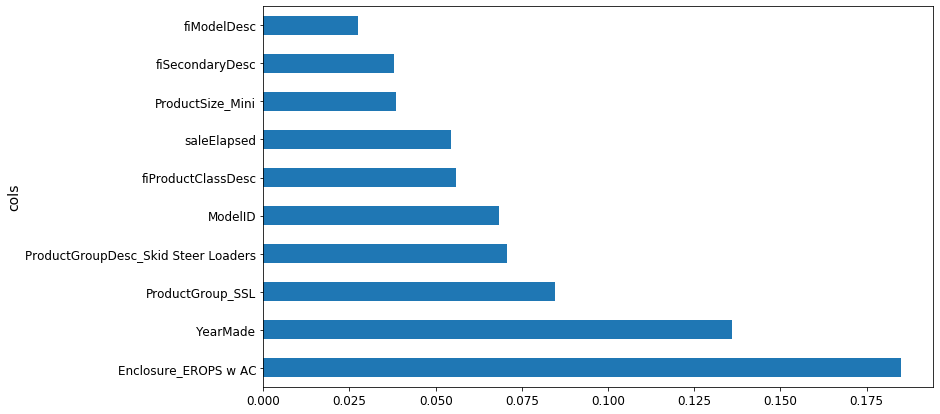

In [53]:
plot_fi(rf_feat_importance(m, df_trn2)[:10]);

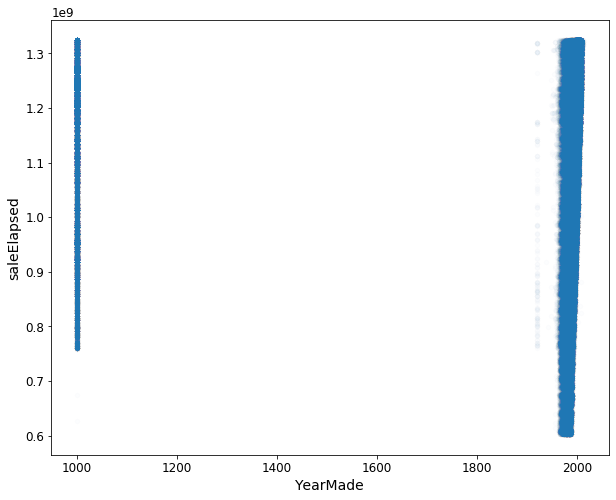

In [54]:
df_raw.plot('YearMade', 'saleElapsed', 'scatter', alpha=0.01, figsize=(10,8));

In [55]:
x_all = get_sample(df_raw[df_raw.YearMade>1930], 500)

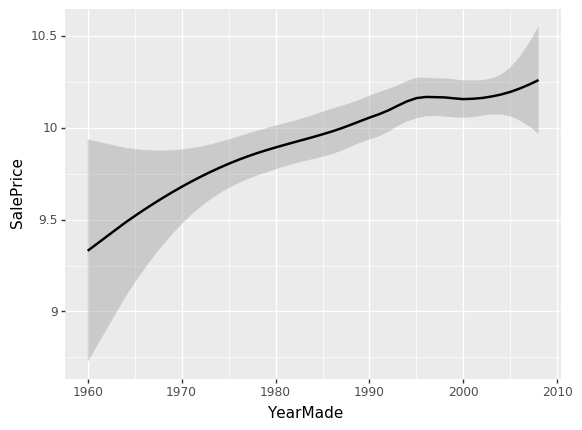

<ggplot: (-9223372029830794822)>

In [56]:
ggplot(x_all, aes('YearMade', 'SalePrice'))+stat_smooth(se=True, method='loess')

In [57]:
x = get_sample(X_train[X_train.YearMade>1930], 500)

In [58]:
def plot_pdp_old(feat, clusters=None, feat_name=None):
    feat_name = feat_name or feat
    p = pdp.pdp_isolate(m, x, feat)
    return pdp.pdp_plot(p, feat_name, plot_lines=True,
                        cluster=clusters is not None,
                        n_cluster_centers=clusters)

In [59]:
def plot_pdp(feat, clusters = None, feat_name = None):
    feat_name = feat_name or feat
    p = pdp.pdp_isolate(m, x, feature = feat, model_features = x.columns)
    return pdp.pdp_plot(p, feat_name, plot_lines = True,
                        cluster = clusters is not None,
                        n_cluster_centers = clusters)

(<Figure size 1080x684 with 2 Axes>,
 {'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x1a263556a0>,
  'pdp_ax': <matplotlib.axes._subplots.AxesSubplot at 0x1a2635efd0>})

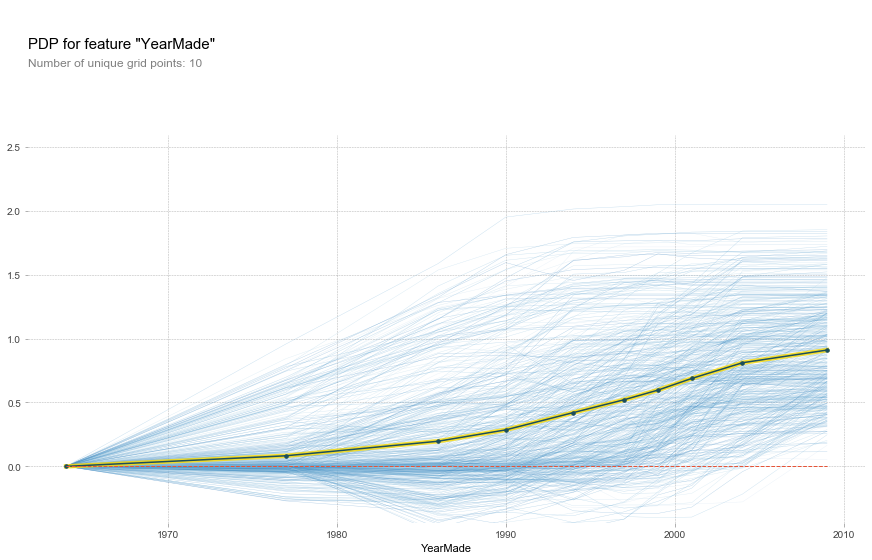

In [60]:
plot_pdp('YearMade')

(<Figure size 1080x684 with 2 Axes>,
 {'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x1a289a9668>,
  'pdp_ax': <matplotlib.axes._subplots.AxesSubplot at 0x1a2899e320>})

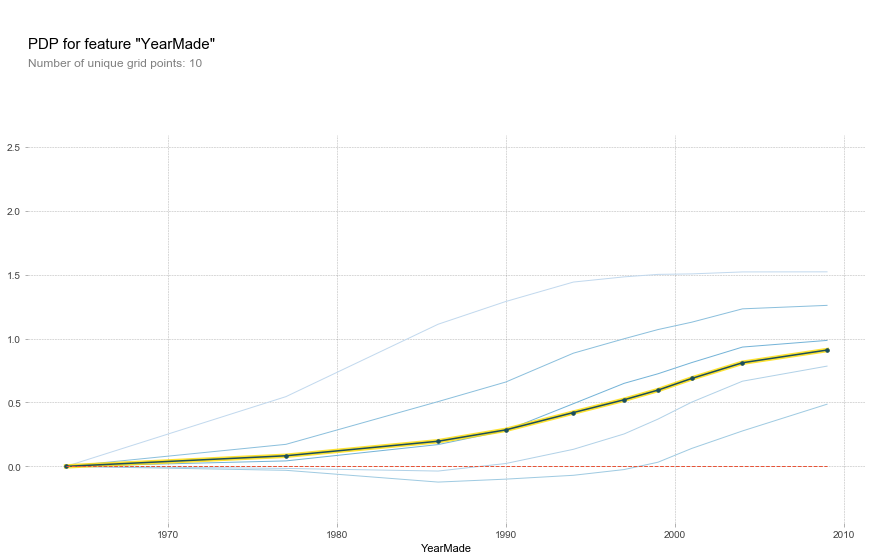

In [61]:
plot_pdp('YearMade', clusters=5)

In [62]:
sorted(list(x.columns))

['Backhoe_Mounting_None or Unspecified',
 'Backhoe_Mounting_Yes',
 'Backhoe_Mounting_nan',
 'Blade_Extension_None or Unspecified',
 'Blade_Extension_Yes',
 'Blade_Extension_nan',
 'Blade_Type',
 "Blade_Width_12'",
 "Blade_Width_13'",
 "Blade_Width_14'",
 "Blade_Width_16'",
 "Blade_Width_<12'",
 'Blade_Width_None or Unspecified',
 'Blade_Width_nan',
 'Coupler_Hydraulic',
 'Coupler_Manual',
 'Coupler_None or Unspecified',
 'Coupler_System_None or Unspecified',
 'Coupler_System_Yes',
 'Coupler_System_nan',
 'Coupler_nan',
 'Differential_Type_Limited Slip',
 'Differential_Type_Locking',
 'Differential_Type_No Spin',
 'Differential_Type_Standard',
 'Differential_Type_nan',
 'Drive_System_All Wheel Drive',
 'Drive_System_Four Wheel Drive',
 'Drive_System_No',
 'Drive_System_Two Wheel Drive',
 'Drive_System_nan',
 'Enclosure_EROPS',
 'Enclosure_EROPS AC',
 'Enclosure_EROPS w AC',
 'Enclosure_NO ROPS',
 'Enclosure_None or Unspecified',
 'Enclosure_OROPS',
 'Enclosure_Type_High Profile',
 'Encl

ignore errors


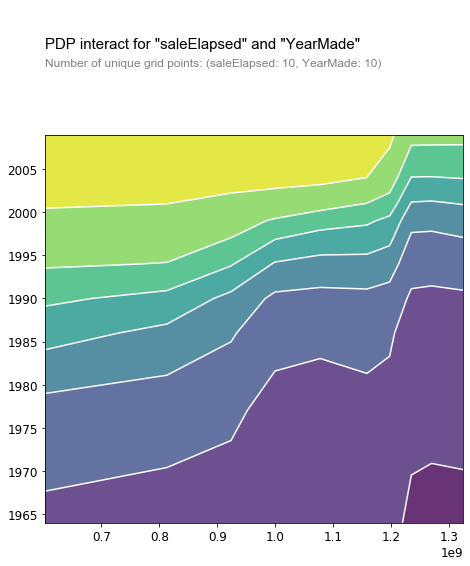

In [63]:
try:
    feats = ['saleElapsed', 'YearMade']
    p = pdp.pdp_interact(m, x, x.columns, feats)
    pdp.pdp_interact_plot(p, feats)
except:
    print("ignore errors")

(<Figure size 1080x684 with 2 Axes>,
 {'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x1a28e3b8d0>,
  'pdp_ax': <matplotlib.axes._subplots.AxesSubplot at 0x1a28fd2b00>})

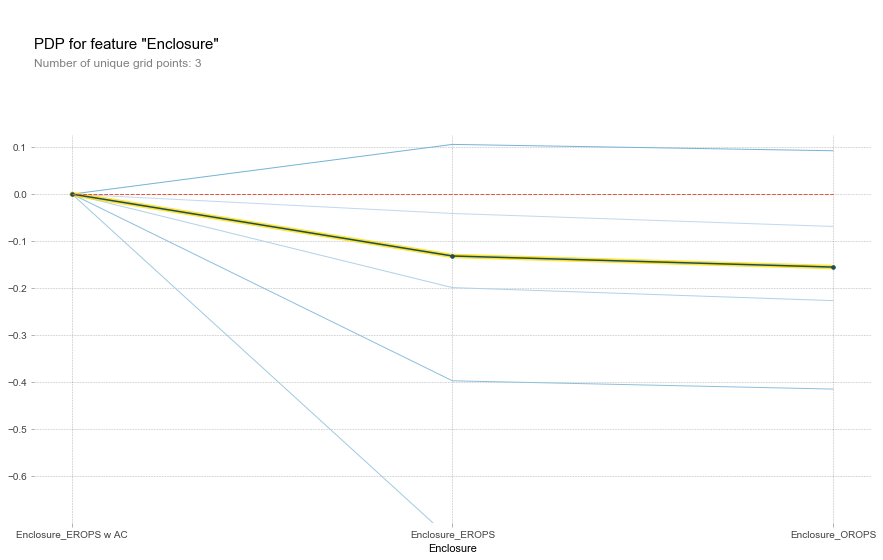

In [64]:
plot_pdp(['Enclosure_EROPS w AC', 'Enclosure_EROPS', 'Enclosure_OROPS'], 5, 'Enclosure')

In [65]:
df_raw.YearMade[df_raw.YearMade<1950] = 1950
df_keep['age'] = df_raw['age'] = df_raw.saleYear-df_raw.YearMade

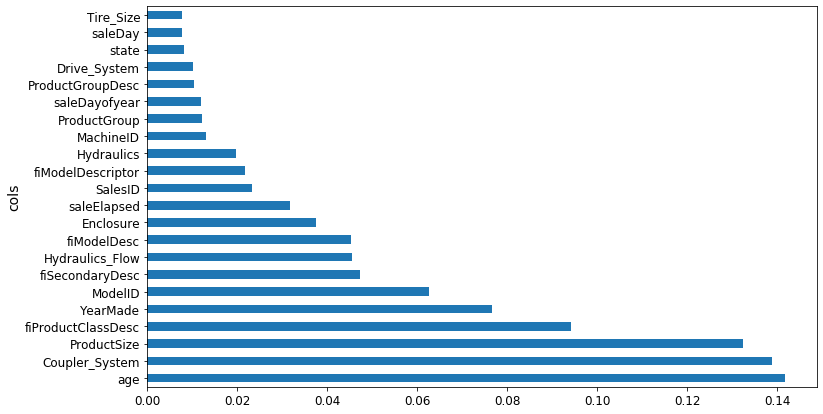

In [66]:
X_train, X_valid = split_vals(df_keep, n_trn)
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.6, n_jobs=-1)
m.fit(X_train, y_train)
plot_fi(rf_feat_importance(m, df_keep));

# Tree interpreter

In [67]:
from treeinterpreter import treeinterpreter as ti

In [68]:
df_train, df_valid = split_vals(df_raw[df_keep.columns], n_trn)

In [69]:
row = X_valid.values[None,0]; row

array([[      1999,          5,          0,         17,          0,        665, 1284595200,          0,
                 1,       3232,    4364751,          0,    2300944,         12,          4,          4,
                 0,         35,        259,         16,          0,         11]])

In [70]:
prediction, bias, contributions = ti.predict(m, row)

In [71]:
prediction[0], bias[0]

(array([9.16208]), 10.105616286467887)

In [72]:
idxs = np.argsort(contributions[0])

In [73]:
pd.concat(
    [pd.DataFrame(contributions[0]),
     pd.DataFrame(contributions[0][idxs]),
     pd.DataFrame(idxs)],
    axis=1
)

,0,0,0
0,0.062427,-0.511886,1
1,-0.511886,-0.255859,3
2,0.063177,-0.155998,21
3,-0.255859,-0.075070,9
4,0.021065,-0.048592,7
5,0.009937,-0.026140,6
6,-0.026140,-0.025164,8
7,-0.048592,-0.021429,11
8,-0.025164,-0.021006,18
9,-0.075070,-0.016665,10


In [74]:
[o for o in zip(df_keep.columns[idxs], df_valid.iloc[0][idxs], contributions[0][idxs])]

[('ProductSize', 'Mini', -0.5118864980841042),
 ('fiProductClassDesc',
  'Hydraulic Excavator, Track - 3.0 to 4.0 Metric Tons',
  -0.2558586552601755),
 ('age', 11, -0.15599838428966323),
 ('fiModelDesc', 'KX1212', -0.07507015084863813),
 ('fiSecondaryDesc', nan, -0.048591966486492846),
 ('saleElapsed', 1284595200, -0.026139947921827122),
 ('Enclosure', 'EROPS', -0.025163722056241556),
 ('fiModelDescriptor', nan, -0.021428998966148784),
 ('saleDayofyear', 259, -0.02100630436636943),
 ('SalesID', 4364751, -0.01666452009025603),
 ('Tire_Size', nan, -0.004668423873540784),
 ('state', 'Ohio', -0.000878302162881317),
 ('saleDay', 16, 0.002959941659749221),
 ('ProductGroup', 'TEX', 0.00857486313929252),
 ('Hydraulics', 'Standard', 0.009210625902163861),
 ('ProductGroupDesc', 'Track Excavators', 0.009423119616152808),
 ('ModelID', 665, 0.009936645311824721),
 ('Drive_System', nan, 0.013653701674323716),
 ('MachineID', 2300944, 0.019390260837591145),
 ('Hydraulics_Flow', nan, 0.021065353438490

In [75]:
contributions[0].sum(), bias[0], contributions[0].sum() + bias[0], prediction[0]

(-0.9435372862310407, 10.105616286467887, 9.162079000236847, array([9.16208]))

# Extrapolation

In [76]:
df_ext = df_keep.copy()
df_ext['is_valid'] = 1
df_ext.is_valid[:n_trn] = 0
x, y, nas = proc_df(df_ext, 'is_valid')

In [77]:
m = RandomForestClassifier(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(x, y);
m.oob_score_

1.0

In [78]:
fi = rf_feat_importance(m, x); fi[:10]

,cols,imp
10,SalesID,0.826515
6,saleElapsed,0.151685
12,MachineID,0.015263
5,ModelID,0.001790
2,Coupler_System,0.001006
9,fiModelDesc,0.000734
0,YearMade,0.000718
18,saleDayofyear,0.000623
7,fiSecondaryDesc,0.000502
8,Enclosure,0.000452


In [79]:
feats=['SalesID', 'saleElapsed', 'MachineID']

In [80]:
(X_train[feats]/1000).describe()

,SalesID,saleElapsed,MachineID
count,389125.000000,3.891250e+05,389125.000000
mean,1800.452485,1.084797e+06,1206.796148
std,595.627288,1.803913e+05,430.850552
min,1139.246000,6.009984e+05,0.000000
25%,1413.348000,9.666432e+05,1087.016000
50%,1632.093000,1.134605e+06,1273.859000
75%,2210.453000,1.234138e+06,1458.661000
max,4364.741000,1.325117e+06,2313.821000


In [81]:
(X_valid[feats]/1000).describe()

,SalesID,saleElapsed,MachineID
count,12000.000000,1.200000e+04,12000.000000
mean,5786.967651,1.306609e+06,1578.049709
std,836.899608,2.497808e+04,589.497173
min,4364.751000,1.174522e+06,0.830000
25%,4408.580750,1.309219e+06,1271.225250
50%,6272.538500,1.316045e+06,1825.317000
75%,6291.792250,1.321402e+06,1907.858000
max,6333.342000,1.325203e+06,2486.330000


In [82]:
x.drop(feats, axis=1, inplace=True)

In [83]:
m = RandomForestClassifier(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(x, y);
m.oob_score_

0.9816391399189779

In [84]:
fi = rf_feat_importance(m, x); fi[:10]

,cols,imp
18,age,0.236566
0,YearMade,0.191172
15,saleDayofyear,0.157362
5,ModelID,0.067821
16,saleDay,0.063655
14,state,0.057406
8,fiModelDesc,0.057278
3,fiProductClassDesc,0.028511
7,Enclosure,0.027530
10,Hydraulics,0.022978


In [85]:
feats=['age', 'YearMade', 'saleDayofyear']

In [86]:
(X_train[feats]).describe()

,age,YearMade,saleDayofyear
count,389125.000000,389125.000000,389125.000000
mean,14.533921,1897.836366,177.640249
std,15.107140,293.277183,103.249389
min,-12.000000,1000.000000,2.000000
25%,5.000000,1984.000000,84.000000
50%,9.000000,1995.000000,166.000000
75%,16.000000,2000.000000,270.000000
max,61.000000,2012.000000,365.000000


In [87]:
(X_valid[feats]).describe()

,age,YearMade,saleDayofyear
count,12000.000000,12000.000000,12000.000000
mean,13.153917,1941.978000,255.770417
std,13.851927,234.918521,82.982391
min,-2.000000,1000.000000,33.000000
25%,6.000000,1997.000000,207.000000
50%,8.000000,2003.000000,266.000000
75%,14.000000,2005.000000,335.000000
max,61.000000,2013.000000,364.000000


In [88]:
set_rf_samples(50000)

In [89]:
feats=['SalesID', 'saleElapsed', 'MachineID',
       'age', 'YearMade', 'saleDayofyear']

In [90]:
X_train, X_valid = split_vals(df_keep, n_trn)
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
get_scores(m, '')

,config,rmse_train,rmse_dev,r2_train,r2_dev,r2_oob,n_trees,train_size,dev_size
0,,0.124612,0.225481,0.967547,0.909204,0.908419,40,389125,12000


In [91]:
for f in feats:
    df_subs = df_keep.drop(f, axis=1)
    X_train, X_valid = split_vals(df_subs, n_trn)
    m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
    m.fit(X_train, y_train)
    print(f)
    display(get_scores(m, ''))

SalesID


,config,rmse_train,rmse_dev,r2_train,r2_dev,r2_oob,n_trees,train_size,dev_size
0,,0.128743,0.223358,0.965359,0.910905,0.908366,40,389125,12000


saleElapsed


,config,rmse_train,rmse_dev,r2_train,r2_dev,r2_oob,n_trees,train_size,dev_size
0,,0.130938,0.233743,0.964169,0.902428,0.903023,40,389125,12000


MachineID


,config,rmse_train,rmse_dev,r2_train,r2_dev,r2_oob,n_trees,train_size,dev_size
0,,0.128289,0.223979,0.965604,0.910409,0.909961,40,389125,12000


age


,config,rmse_train,rmse_dev,r2_train,r2_dev,r2_oob,n_trees,train_size,dev_size
0,,0.125688,0.22708,0.966984,0.907911,0.908936,40,389125,12000


YearMade


,config,rmse_train,rmse_dev,r2_train,r2_dev,r2_oob,n_trees,train_size,dev_size
0,,0.125924,0.228054,0.96686,0.90712,0.908365,40,389125,12000


saleDayofyear


,config,rmse_train,rmse_dev,r2_train,r2_dev,r2_oob,n_trees,train_size,dev_size
0,,0.128793,0.226791,0.965333,0.908146,0.907622,40,389125,12000


In [92]:
# reset_rf_samples()

In [93]:
# for comparison

In [94]:
X_train, X_valid = split_vals(df_keep, n_trn)
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features=0.5, max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=3,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=40, n_jobs=-1, oob_score=True,
                      random_state=None, verbose=0, warm_start=False)

In [95]:
tmp = get_scores(m, 'before-remove')
tmp

,config,rmse_train,rmse_dev,r2_train,r2_dev,r2_oob,n_trees,train_size,dev_size
0,before-remove,0.124588,0.22649,0.967559,0.908389,0.908737,40,389125,12000


In [96]:
results = pd.concat([tmp, results])
results[::-1]

,config,rmse_train,rmse_dev,r2_train,r2_dev,r2_oob,n_trees,train_size,dev_size
0,baseline-subsample-tuning,0.119149,0.229098,0.970330,0.906267,0.911704,40,389125,12000
0,fi,0.124037,0.225316,0.967846,0.909337,0.910046,40,389125,12000
0,one-hot,0.118197,0.233198,0.970802,0.902882,0.910315,40,389125,12000
0,baseline-slow-dedup,0.125889,0.226689,0.966879,0.908229,0.908421,40,389125,12000
0,before-remove,0.124588,0.226490,0.967559,0.908389,0.908737,40,389125,12000


In [97]:
df_subs = df_keep.drop(['SalesID', 'MachineID', 'saleDayofyear'], axis=1)
X_train, X_valid = split_vals(df_subs, n_trn)
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features=0.5, max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=3,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=40, n_jobs=-1, oob_score=True,
                      random_state=None, verbose=0, warm_start=False)

In [98]:
tmp = get_scores(m, 'after-remove')
tmp

,config,rmse_train,rmse_dev,r2_train,r2_dev,r2_oob,n_trees,train_size,dev_size
0,after-remove,0.138596,0.218533,0.959855,0.914713,0.909164,40,389125,12000


In [99]:
results = pd.concat([tmp, results])
results[::-1]

,config,rmse_train,rmse_dev,r2_train,r2_dev,r2_oob,n_trees,train_size,dev_size
0,baseline-subsample-tuning,0.119149,0.229098,0.970330,0.906267,0.911704,40,389125,12000
0,fi,0.124037,0.225316,0.967846,0.909337,0.910046,40,389125,12000
0,one-hot,0.118197,0.233198,0.970802,0.902882,0.910315,40,389125,12000
0,baseline-slow-dedup,0.125889,0.226689,0.966879,0.908229,0.908421,40,389125,12000
0,before-remove,0.124588,0.226490,0.967559,0.908389,0.908737,40,389125,12000
0,after-remove,0.138596,0.218533,0.959855,0.914713,0.909164,40,389125,12000


In [100]:
reset_rf_samples()

In [101]:
df_subs = df_keep.drop(['SalesID', 'MachineID', 'saleDayofyear'], axis=1)
X_train, X_valid = split_vals(df_subs, n_trn)
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features=0.5, max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=3,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=40, n_jobs=-1, oob_score=True,
                      random_state=None, verbose=0, warm_start=False)

In [102]:
tmp = get_scores(m, 'full')
tmp

,config,rmse_train,rmse_dev,r2_train,r2_dev,r2_oob,n_trees,train_size,dev_size
0,full,0.138444,0.217977,0.959943,0.915147,0.909467,40,389125,12000


In [103]:
results = pd.concat([tmp, results])
results[::-1]

,config,rmse_train,rmse_dev,r2_train,r2_dev,r2_oob,n_trees,train_size,dev_size
0,baseline-subsample-tuning,0.119149,0.229098,0.970330,0.906267,0.911704,40,389125,12000
0,fi,0.124037,0.225316,0.967846,0.909337,0.910046,40,389125,12000
0,one-hot,0.118197,0.233198,0.970802,0.902882,0.910315,40,389125,12000
0,baseline-slow-dedup,0.125889,0.226689,0.966879,0.908229,0.908421,40,389125,12000
0,before-remove,0.124588,0.226490,0.967559,0.908389,0.908737,40,389125,12000
0,after-remove,0.138596,0.218533,0.959855,0.914713,0.909164,40,389125,12000
0,full,0.138444,0.217977,0.959943,0.915147,0.909467,40,389125,12000


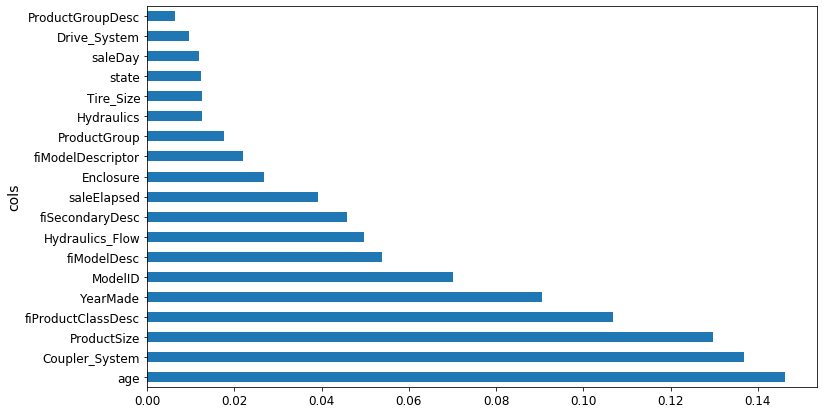

In [104]:
plot_fi(rf_feat_importance(m, X_train));

In [105]:
np.save('tmp/subs_cols.npy', np.array(df_subs.columns))

# Our final model!

In [106]:
m = RandomForestRegressor(n_estimators=160, max_features=0.5, n_jobs=-1, oob_score=True)
%time m.fit(X_train, y_train)
get_scores(m, "final")

CPU times: user 4min 34s, sys: 9.17 s, total: 4min 43s
Wall time: 36.9 s


,config,rmse_train,rmse_dev,r2_train,r2_dev,r2_oob,n_trees,train_size,dev_size
0,final,0.080152,0.211189,0.986573,0.920349,0.91465,160,389125,12000


In [107]:
tmp = get_scores(m, "final")
tmp

,config,rmse_train,rmse_dev,r2_train,r2_dev,r2_oob,n_trees,train_size,dev_size
0,final,0.080152,0.211189,0.986573,0.920349,0.91465,160,389125,12000


In [108]:
results = pd.concat([tmp, results])
results[::-1]

,config,rmse_train,rmse_dev,r2_train,r2_dev,r2_oob,n_trees,train_size,dev_size
0,baseline-subsample-tuning,0.119149,0.229098,0.970330,0.906267,0.911704,40,389125,12000
0,fi,0.124037,0.225316,0.967846,0.909337,0.910046,40,389125,12000
0,one-hot,0.118197,0.233198,0.970802,0.902882,0.910315,40,389125,12000
0,baseline-slow-dedup,0.125889,0.226689,0.966879,0.908229,0.908421,40,389125,12000
0,before-remove,0.124588,0.226490,0.967559,0.908389,0.908737,40,389125,12000
0,after-remove,0.138596,0.218533,0.959855,0.914713,0.909164,40,389125,12000
0,full,0.138444,0.217977,0.959943,0.915147,0.909467,40,389125,12000
0,final,0.080152,0.211189,0.986573,0.920349,0.914650,160,389125,12000


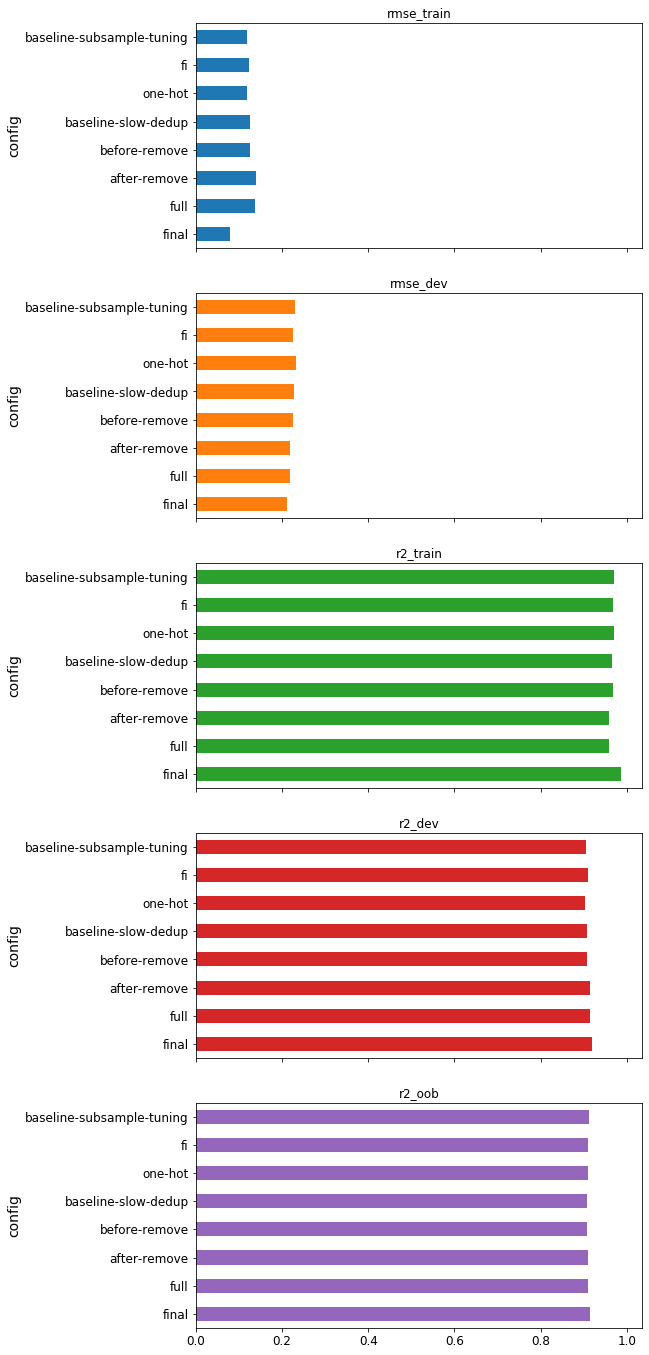

In [109]:
cols = results.columns[:6]
results[cols].plot.barh(
    x='config',
    subplots=True,
    # rot=90,
    # ylim=(0,1),
    # title=['']*4,
    legend=False,
    figsize=(8,3*results.shape[0])
);